# Starbucks Capstone Challenge - Data Exploration and Feature Engineering



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [3]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploring the Portfolio dataset

In [4]:
portfolio.head(5)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
portfolio.shape

(10, 6)

*Let's check missing values*

In [7]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

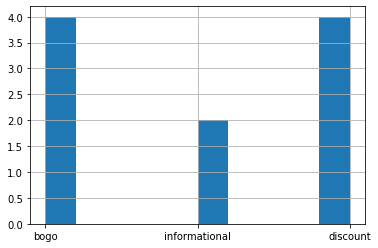

In [8]:
#what is the offer_type distribution
portfolio['offer_type'].hist()

### Details from the dataset

The unit of the columns **rewards** and **difficulty** is dollars, the name *difficulty* could be a bit confussing because it conveys the minimun value to be spent to complete the offer, and not how diificult is it to be completed.

There is no missing or negative values on these columns.

It is interesting that **discounts** offers are sent only by email and web, not by the mobile app.

## Exploring the profile dataset

In [9]:
profile.shape

(17000, 5)

In [10]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are **2175** values missing in the gender and income columns, and it seems that age is **118** when those two column  values are missing. I will drop those records them from the dataset.

In [12]:
profile.dropna(inplace=True)
profile.shape

(14825, 5)

Lets see now the age distribution

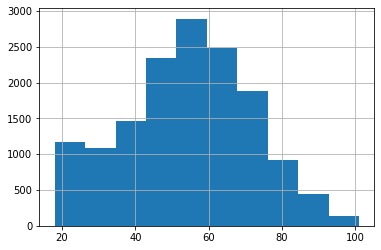

In [13]:
profile['age'].hist()

In [14]:
profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [15]:
profile.loc[profile['age']>66].shape[0]

3702

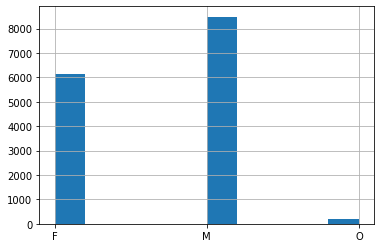

In [16]:
#Lets see now gender distribution
profile['gender'].hist()

In [17]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

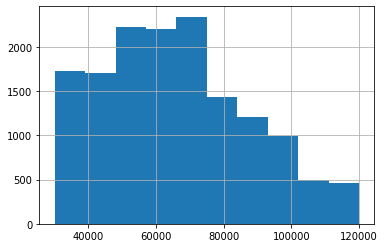

In [18]:
#Lets see now income distribution
profile['income'].hist()

In [19]:
#Lets see now gender distribution
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Text(0.5, 1.0, 'Other')

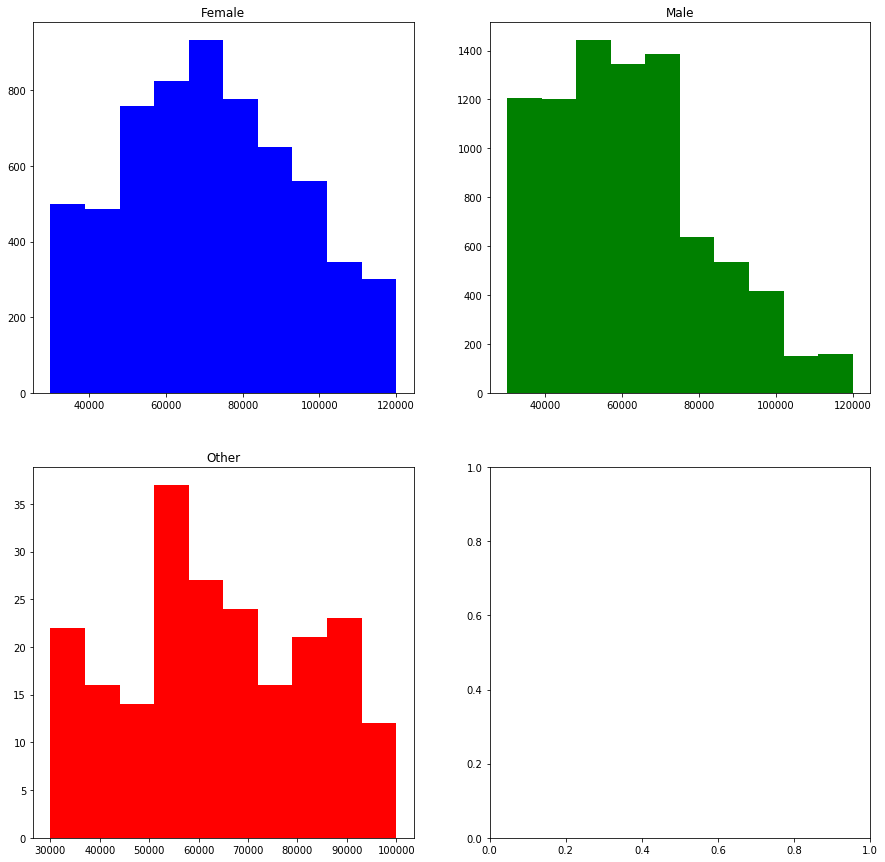

In [721]:
genders = profile['gender'].unique()
fig, axs = plt.subplots(2,2,figsize=(15,15))
colors = ['b','g','r']
axs[0,0].hist(profile.loc[profile['gender']=='F','income'],bins=10,histtype='bar',color=colors[0])
axs[0,0].set_title('Female')
axs[0,1].hist(profile.loc[profile['gender']=='M','income'],bins=10,histtype='bar',color=colors[1])
axs[0,1].set_title('Male')
axs[1,0].hist(profile.loc[profile['gender']=='O','income'],bins=10,histtype='bar',color=colors[2])
axs[1,0].set_title('Other')

In [20]:
genders = profile['gender'].unique()
for gender in genders:
    u = profile.loc[profile['gender']==gender,'income'].mean()
    print('{gender} Mean income is: {mean}'.format( gender=gender,mean=u))

F Mean income is: 71306.41213901126
M Mean income is: 61194.60160301744
O Mean income is: 63287.735849056604


Empirically we could think that income could be a relevant feature for the classification model we are trying to create, however a later formal analysis of the correlation of features of the model will give us the answer. For now it would be a good idea to create a new column where to have the income value scaled.

It is important to analyze the distribution of the **became_member_on** column as this can be an important feature within the model that defines a client and could help predict whether the offer will be completed or not. Before that it is necessary to process this column in order to use a more appropiate format.

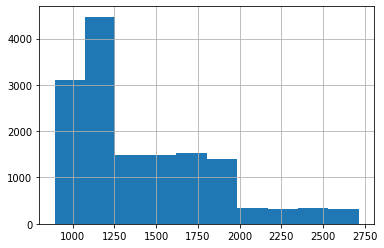

In [22]:
import datetime
from datetime import datetime as dt

profile['member_since'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['total_days_of_membership'] = (dt.today().date() - profile['member_since'].dt.date).dt.days
profile['total_days_of_membership'].hist() 

In [23]:
profile['total_days_of_membership'].describe()

count    14825.000000
mean      1414.478988
std        419.205158
min        892.000000
25%       1100.000000
50%       1250.000000
75%       1689.000000
max       2715.000000
Name: total_days_of_membership, dtype: float64

According to the **total_days_of_membership** distribution, we can cluster this column in three categories 
   
    1     - 1093 days   :  0
    1094  - 1683 days   :  1
    > 1683              :  2

## Details from the dataset

The majority of clients are men (8484), followed by women (6129) and only 212 clients define their gender as other.

The average age of the clients is 54 years old. There are **3702** clients over 66 years old, which is **25%**.

The median income is 65400 dollars

Women's average income (71,306) is higher than men's (61,195) and than the average in the data set (65405)

The income range is from 30,000 to 120,000 

The average days of membership is 1408 days



## Exploring the Transcript dataset

In [24]:
transcript.shape

(306534, 4)

In [25]:
## Lers check for missing values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

There is no missing values is the transcript dataset

In [26]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


The **value** columns is a dictionary, we need to know what keys are used.

In [27]:
#lets see what are the keys in transcript.value

for event_name in transcript['event'].unique():
    subset = transcript[transcript['event']==event_name]
    if (type (subset.iloc[0,2]) is dict ):
       print("{}  :  {}".format(event_name,subset.iloc[0,2].keys()))

offer received  :  dict_keys(['offer id'])
offer viewed  :  dict_keys(['offer id'])
transaction  :  dict_keys(['amount'])
offer completed  :  dict_keys(['offer_id', 'reward'])


And also see the distribution of events

In [28]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

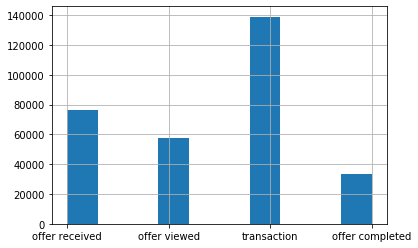

In [29]:
transcript['event'].hist()

In order to prepare the training dataset, a column will be added  to the transcript dataframe for each key that is in the Value column, we already know that they are (amount, reward, offer_id and offer id ) 

In [30]:
def determine_offerid_value(d):
    return d['offer_id'] if (d.get('offer_id') is not None) else d.get('offer id')

In [31]:
transcript.loc[:,'offer_id'] = transcript['value'].apply(lambda d: determine_offerid_value(d) if (type(d) is dict) else ' ')

In [32]:
transcript.loc[:,'amount'] = transcript[transcript['event']=='transaction']['value'].apply(lambda d: d['amount'])

In [33]:
transcript.loc[:,'reward'] = transcript[transcript['event']=='offer completed']['value'].apply(lambda d: d['reward'])

Let's see how the data looks for a specific client, we are going to eliminate the transaction type events, since we are interested in knowing the offers that were seen and then completed or not

In [34]:
transcript.loc[ (transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef') & (transcript['event']!='transaction'), ['person','event','offer_id','time'] ]

,person,event,offer_id,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,6
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,132
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,5a8bc65990b245e5a138643cd4eb9837,216
150598,78afa995795e4d85b5d9ceeca43f5fef,offer received,ae264e3637204a6fb9bb56bc8210ddfd,408
163375,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,ae264e3637204a6fb9bb56bc8210ddfd,408
201572,78afa995795e4d85b5d9ceeca43f5fef,offer received,f19421c1d4aa40978ebb69ca19b0e20d,504
218394,78afa995795e4d85b5d9ceeca43f5fef,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,510
218395,78afa995795e4d85b5d9ceeca43f5fef,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,510


### The time feature

The **time** feature indicates the time of occurrence of an event since the beginning of the test. This feature can be important to implement heuristics or to calculate statistics such as the average time for customers to complete an offer. It can also be used to create a regression model with which to predict the customer response time to complete an offer. In the case of this particular project the idea is to create a classification model that predicts whether an offer will be completed or not, we will eliminate this feature from the training data set being created as we consider it not relevant to the model.

## Feature engineering


One of the main objectives of this project is to create a data model based on demographic information composed of relevant information from the profile, portfolio and transcript datasets, which is the basis for a classification model with which to predict whether an offering will be successfully completed or not.

The following are the steps to follow:

    Merge training dataset with profile
    Merge training dataset with portfolio
    scale income
    scale age
    one hot encode offer_type
    one hot encode gender
    create categories for total_days_of_membership    
    remove person id
    remove offer id


In [35]:
training_df = transcript.copy()

In [36]:
profile =  profile.rename(columns={'id':'person'})
profile.set_index(['person'])

,gender,age,became_member_on,income,member_since,total_days_of_membership
person,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0,2017-07-15,1268
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,2017-05-09,1335
e2127556f4f64592b11af22de27a7932,M,68,20180426,70000.0,2018-04-26,983
389bc3fa690240e798340f5a15918d5c,M,65,20180209,53000.0,2018-02-09,1059
2eeac8d8feae4a8cad5a6af0499a211d,M,58,20171111,51000.0,2017-11-11,1149
...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.0,2018-06-04,944
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.0,2018-07-13,905
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.0,2017-01-26,1438


As our model is based on working with successful offers, i.e. those received, viewed and completed, we will not take into account transaction-type events

In [37]:
training_df   =  pd.merge( training_df , profile[['person','gender', 'age','total_days_of_membership','income']], 
                                                          on='person', how='right')
training_df = training_df.loc[training_df['event'].isin(['offer viewed','offer completed','offer received'])]


In [38]:
portfolio =  portfolio.rename(columns={'id':'offer_id'})
portfolio.set_index(['offer_id'])

training_df   =  pd.merge( training_df , portfolio[['offer_id','reward', 'difficulty','duration', 'offer_type']], 
                                                          on='offer_id', how='left')



### Ordinal representation or One Hot Encoding?

For the features **gender** and **offer type** one might consider converting them into an ordinal representation such as 1 = BOGO, 2 = INFORMATIONAL and 3 = DISCOUNT, however this might cause the model to learn that INFORMATIONAL and DISCOUNT are more similar than BOGO and DISCOUNT, since in reality there is no ordinal relationship between them. The same for the GENDER feature. Therefore it is better to make a One Hot Encoder representation for the features gender and offer_type.

In [39]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


scaler = preprocessing.MinMaxScaler()
training_df['std_income'] = scaler.fit_transform(training_df[['income']])
training_df['std_age']    = scaler.fit_transform(training_df[['age']])

#one hot encode offer_type
enc = OneHotEncoder(handle_unknown='ignore')
enc_offer = pd.DataFrame(enc.fit_transform(  pd.DataFrame(training_df['offer_type'])  ).toarray())

feature_labels = enc.categories_
feature_labels = np.array(feature_labels).ravel()
enc_offer.columns = feature_labels

#one hot encode gender
enc_g = OneHotEncoder(handle_unknown='ignore')
enc_gender = pd.DataFrame(enc_g.fit_transform(pd.DataFrame(training_df['gender'])).toarray())

feature_labels = enc_g.categories_
feature_labels = np.array(feature_labels).ravel()
enc_gender.columns = feature_labels

training_df = training_df.join(enc_offer)
training_df = training_df.join(enc_gender)
training_df

,person,event,value,time,offer_id,amount,reward_x,gender,age,total_days_of_membership,...,duration,offer_type,std_income,std_age,bogo,discount,informational,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,1335,...,7,bogo,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,1335,...,7,bogo,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,F,75,1335,...,7,bogo,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,F,75,1335,...,3,informational,0.777778,0.686747,0.0,0.0,1.0,1.0,0.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,F,75,1335,...,3,informational,0.777778,0.686747,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148800,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,47,1178,...,4,informational,0.711111,0.349398,0.0,0.0,1.0,0.0,1.0,0.0
148801,9fcbff4f8d7241faa4ab8a9d19c8a812,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,M,47,1178,...,5,bogo,0.711111,0.349398,1.0,0.0,0.0,0.0,1.0,0.0
148802,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,M,47,1178,...,5,bogo,0.711111,0.349398,1.0,0.0,0.0,0.0,1.0,0.0
148803,3045af4e98794a04a5542d3eac939b1f,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,F,58,1536,...,5,bogo,0.533333,0.481928,1.0,0.0,0.0,1.0,0.0,0.0


### How to determine successful offers? a key element in drawing valuable conclusions 

A key element in being able to do a powerful data analysis and implement a successful model is being able to determine the successful offers, i.e. those that were received, viewed and completed. 

The following function has that objective. Here we assume that for an offer to be successful, (for a particular client and offer, to be exact) it must have three successive events in the following **strict** order: 

    offer received
    offer viewed
    offer completed
 

In [40]:

training_df = training_df.drop(columns=['value','amount','reward_x'])
training_df =  training_df.rename(columns={'reward_y':'reward'})

In [41]:
#The objective of this function is to mark the offers received that were successfully completed
def determine_offer_completed(person,offer_id,time):  
    
    result = training_df.loc[  (training_df['person']   == person) 
                               & (training_df['offer_id'] == offer_id) 
                               & (training_df['time']>time), ['event','time']
                             ].sort_values(['time'],ascending=True).head(2)['event']   
  
    completed = (len(result)==2) and (result.iloc[[0][0]]=='offer viewed') and (result.iloc[[1][0]]=='offer completed')
    return (1.0 if completed else 0.0)



So the algorithm starts creating a new column called completed, initialized with the value 0.0. It then scans all the offers received and updates this value to 1.0 or 0.0 depending on whether the offer was completed by the customer or not.

In [48]:
training_df['completed'] = 0.0

# we will process all the offers received to determine whether or not they were successfully completed

training_df['completed'] = ( training_df.loc[training_df['event']=='offer received']
                            .apply(lambda x: determine_offer_completed(x.person, x.offer_id, x.time), axis=1) )
training_df.fillna(0.0, inplace = True)


In [50]:
training_df = training_df.loc[training_df['event']=='offer received'].copy()

total_completed = len(training_df.loc[ (training_df['event']=='offer received') & (training_df['completed']==1.0) ])
percentage_completed = (total_completed / len(training_df.loc[ (training_df['event']=='offer received')])) * 100
print('Total offers completed {total}'.format(total=total_completed))
print('Percentage offers Completed {total}'.format(total=percentage_completed))


Total offers completed 16173
Percentage offers Completed 24.319935038570847


It is clear that our dataset has a significant degree of imbalance between completed and uncompleted offers, with completed offers representing only approximately 25% of the total.

Class imbalance affects **accuracy** negatively, so something must be done so that model performance can still be evaluated using accuracy. This indicates that we should use a strategy to manage imbalanced classes, either by some method of increasing the minority class samples or decreasing the majority class samples or by using a classification model that is little affected by the class imbalance 

#### Preprocessing of Total days of membership

Lets create categories for the column **total_days_of_membership** based on the inter quartyle ranges

    1     - 1093 days   :  0
    1094  - 1683 days   :  1
    > 1683              :  2

In [42]:
def categorize_tot_days_membership(days):
    if days in range (1,1093):
        return 0
    elif days in range (1094,1683):
        return 1
    else:
        return 2
        
training_df['type_of_membership'] =  training_df['total_days_of_membership'].apply(lambda x: categorize_tot_days_membership(x))  

## Insight from the dataset

    Offers completed by genre
    Offers completed by offer type
    Offers completed by income

### Offers completed by gender

In [51]:
training_df.groupby(['gender','completed'])['completed'].count()

gender  completed
F       0.0          19904
        1.0           7552
M       0.0          29768
        1.0           8361
O       0.0            656
        1.0            260
Name: completed, dtype: int64

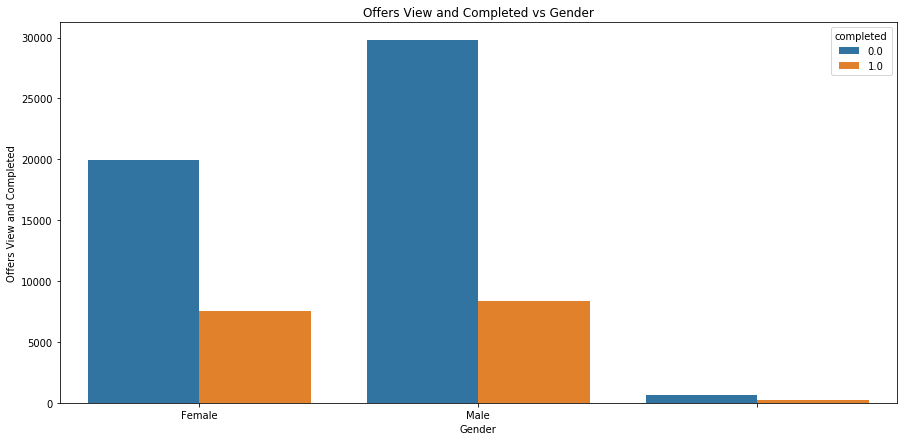

In [55]:
import seaborn as sns

plt.figure(figsize=(15, 7))
g = sns.countplot(x="gender", hue="completed", data=training_df)
plt.title('Offers View and Completed vs Gender')
plt.ylabel('Offers View and Completed')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

#### Women complete more offers than men.

### What are the types of offers most completed by clients?

In [910]:
training_df.groupby(['offer_type','completed'])['completed'].count()

offer_type     completed
bogo           0.0          18954
               1.0           7583
discount       0.0          18074
               1.0           8590
informational  0.0          13300
Name: completed, dtype: int64

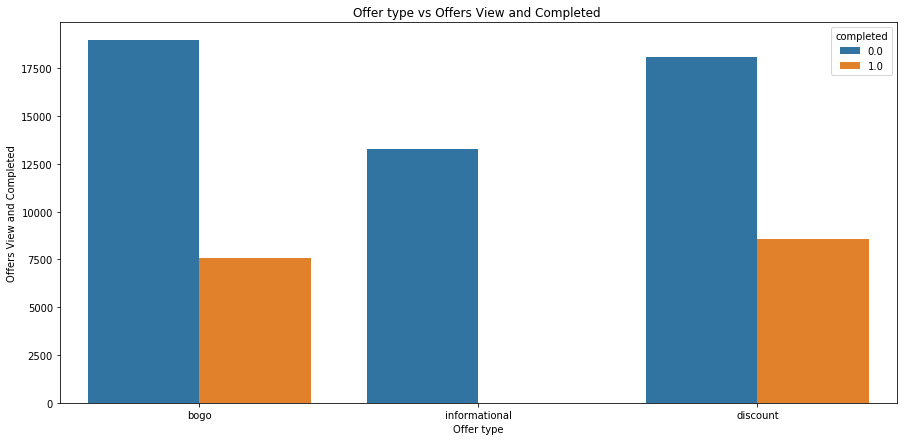

In [908]:
plt.figure(figsize=(15, 7))
g = sns.countplot(x="offer_type", hue="completed", data=training_df)
plt.title('Offer type vs Offers View and Completed ')
plt.ylabel('Offers View and Completed')
plt.xlabel('Offer type')
plt.xticks(rotation = 0)
plt.show();

#### The most successful type of offer is DISCOUNT

### How long a customer has been on the platform is related to successful offers?

In [53]:
training_df.groupby(['type_of_membership','completed'])['completed'].count()

type_of_membership  completed
0                   0.0          13472
                    1.0           2414
1                   0.0          24973
                    1.0           8657
2                   0.0          11883
                    1.0           5102
Name: completed, dtype: int64

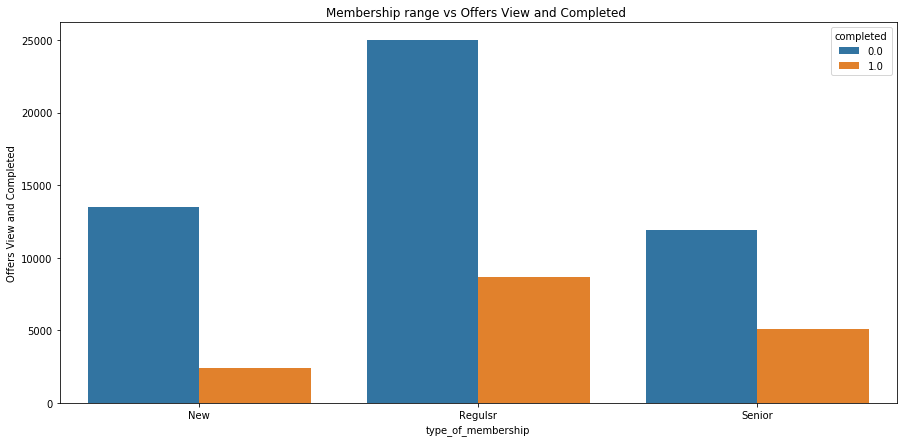

In [56]:
plt.figure(figsize=(15, 7))
g = sns.countplot(x="type_of_membership", hue="completed", data=training_df)
plt.title('Membership range vs Offers View and Completed ')
plt.ylabel('Offers View and Completed')
xlabels = ['New', 'Regulsr' , 'Senior']
g.set_xticklabels(xlabels)
plt.xlabel('type_of_membership')
plt.xticks(rotation = 0)
plt.show();

#### The oldest customers on the platform are the ones who complete the most offers

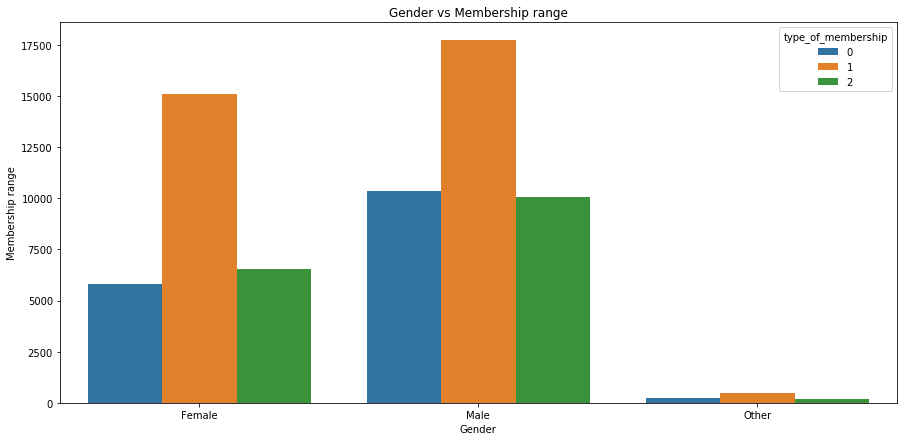

In [906]:
plt.figure(figsize=(15, 7))
g = sns.countplot(x="gender", hue="type_of_membership", data=training_df)
plt.title('Gender vs Membership range')
plt.ylabel('Membership range')
xlabels = ['Female', 'Male' , 'Other']
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

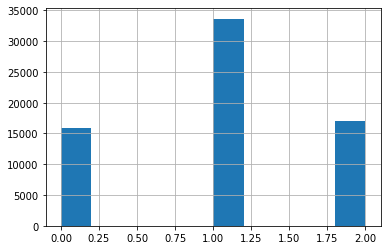

In [57]:
training_df['type_of_membership'].hist()

In [58]:
print(training_df.columns)
training_df.head(10)

Index(['person', 'event', 'time', 'offer_id', 'gender', 'age',
       'total_days_of_membership', 'income', 'reward', 'difficulty',
       'duration', 'offer_type', 'std_income', 'std_age', 'bogo', 'discount',
       'informational', 'F', 'M', 'O', 'type_of_membership', 'completed'],
      dtype='object')


,person,event,time,offer_id,gender,age,total_days_of_membership,income,reward,difficulty,...,std_income,std_age,bogo,discount,informational,F,M,O,type_of_membership,completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,1335,100000.0,5,5,...,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0,1,1.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,F,75,1335,100000.0,0,0,...,0.777778,0.686747,0.0,0.0,1.0,1.0,0.0,0.0,1,0.0
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,ae264e3637204a6fb9bb56bc8210ddfd,F,75,1335,100000.0,10,10,...,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0
7,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,F,75,1335,100000.0,5,5,...,0.777778,0.686747,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0
11,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,M,68,983,70000.0,2,10,...,0.444444,0.602410,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0
13,e2127556f4f64592b11af22de27a7932,offer received,336,3f207df678b143eea3cee63160fa8bed,M,68,983,70000.0,0,0,...,0.444444,0.602410,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0
14,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,983,70000.0,5,5,...,0.444444,0.602410,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
16,e2127556f4f64592b11af22de27a7932,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,M,68,983,70000.0,2,10,...,0.444444,0.602410,0.0,1.0,0.0,0.0,1.0,0.0,0,1.0
20,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,M,65,1059,53000.0,5,5,...,0.255556,0.566265,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0
23,389bc3fa690240e798340f5a15918d5c,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,65,1059,53000.0,5,5,...,0.255556,0.566265,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0


### Correlations

Now that we have a complete data set, it is now important to analyze the correlation between the different features.

Let's first eliminate the categorical columns and the redundant ones after scaling and one hot encoding. 

In [65]:
training_df = training_df.drop(columns=['person', 'event', 'offer_id', 'gender', 'age', 'income','offer_type','total_days_of_membership','time'] )
training_df.columns

Index(['reward', 'difficulty', 'duration', 'std_income', 'std_age', 'bogo',
       'discount', 'informational', 'F', 'M', 'O', 'type_of_membership',
       'completed'],
      dtype='object')

In [66]:
correlation_matrix = training_df.corr()
correlation_matrix['completed'].sort_values(ascending=False)

completed             1.000000
duration              0.196006
discount              0.150572
difficulty            0.129000
reward                0.125238
type_of_membership    0.120718
std_income            0.088242
bogo                  0.080825
F                     0.062272
std_age               0.036803
O                     0.011196
M                    -0.064629
informational        -0.283437
Name: completed, dtype: float64

it can be seen that the features most correlated to a successful offer(completed=1.0) are (in descending order): **duration,discount,difficulty,reward and type of membership ( which was derived from total_days_of_membership)**

### Saving the base dataset

For now let's save the base data set to be used in the training notebook.

In [67]:
from sklearn.model_selection import train_test_split

training_df.to_csv('data/dataset.csv',index=False) 